In [1]:
!pip install torch torchvision -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as DataLoader

#### Define transformations: convert to tensor and normalize (mean=0.5, std=0.5 for grayscale)

MNIST images are 28x28 pixels, grayscale, with 60,000 training and 10,000 test images. We’ll normalize the pixel values and load the data using PyTorch’s DataLoader.

In [3]:
# Define transformations: convert to tensor and normalize (mean=0.5, std=0.5 for grayscale)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=0.5,std=0.5)])

In [4]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',train=True,transform=transform,download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,transform=transform,download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 166kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.21MB/s]


#Explanation:

###**transforms.ToTensor():** Converts images to PyTorch tensors (shape: [1, 28, 28] for grayscale).
###**transforms.Normalize((0.5,), (0.5,)):** Normalizes pixel values to [-1, 1] for faster training.
###**DataLoader:** Batches data (64 images per batch), shuffles training data, and loads it efficiently.

In [5]:
# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

#Define the CNN Model

###We’ll create a simple CNN with **two convolutional layers, max-pooling, and fully connected layers.**

#Explanation:

###**nn.Module:** Base class for the CNN. We define layers in __init__ and the forward pass in forward.
###**nn.Conv2d:** Convolutional layer. For example, conv1 takes 1-channel input (grayscale), outputs 16 feature maps, uses a 3x3 kernel, and padding=1 to maintain size.
###**nn.ReLU:** Activation function for non-linearity.
###**nn.MaxPool2d:** Downsamples feature maps (e.g., 28x28 → 14x14).
###**view:** Flattens the tensor for fully connected layers.
The final output is 10 values (one per digit), which we’ll pass through a softmax during loss calculation.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First conv layer: input 1 channel (grayscale), output 16 channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        # Second conv layer: input 16 channels, output 32 channels, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # After pooling, image size is 7x7
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (digits 0–9)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]
        x = self.pool(self.relu(self.conv1(x)))  # Output: [batch_size, 16, 14, 14]
        x = self.pool(self.relu(self.conv2(x)))  # Output: [batch_size, 32, 7, 7]
        x = x.view(-1, 32 * 7 * 7)  # Flatten to [batch_size, 32*7*7]
        x = self.relu(self.fc1(x))  # Output: [batch_size, 128]
        x = self.fc2(x)  # Output: [batch_size, 10]
        return x

In [7]:
# Instantiate model
model = CNN()

##Set Up Loss Function and Optimizer
We use **cross-entropy loss** (common for classification) and the Adam optimizer.

#Explanation:

###**nn.CrossEntropyLoss:** Computes the loss between predicted probabilities and true labels.
###**optim.Adam:** Optimizes model parameters with a learning rate of 0.001.

In [8]:
criterion = nn.CrossEntropyLoss()  # Combines softmax and loss calculation
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train the Model
We’ll train for 5 epochs, processing batches and updating weights.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#Explanation:

###**model.train():** Enables training mode (e.g., activates dropout if used).
###**optimizer.zero_grad():** Clears old gradients.
###**loss.backward():** Computes gradients via autograd.
###**optimizer.step():** Updates weights.
The loop processes batches, computes loss, and updates the model.

In [10]:
for epoch in range(5):
  model.train()   # set model to train mode
  running_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    #zero grad
    optimizer.zero_grad()
    #forward pass
    outputs = model(images)
    #calculate loss
    loss = criterion(outputs, labels)
    #backward pass
    loss.backward()
    #update weights
    optimizer.step()
    #update loss
    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.2259
Epoch 2, Loss: 0.0987
Epoch 3, Loss: 0.0837
Epoch 4, Loss: 0.0834
Epoch 5, Loss: 0.0779


#Evaluate the Model
Test the model on the test dataset to compute accuracy.

In [11]:
model.eval()   # set model to evaluate mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation for inference (as its test data)
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total}%")

Accuracy on the test set: 98.16%



Experiment: Batch Size=32, Learning Rate=0.001, Dropout=0.5
Epoch 1, Loss: 0.1476
Epoch 2, Loss: 0.0471
Epoch 3, Loss: 0.0328
Epoch 4, Loss: 0.0239
Epoch 5, Loss: 0.0183
Test Accuracy: 98.91%


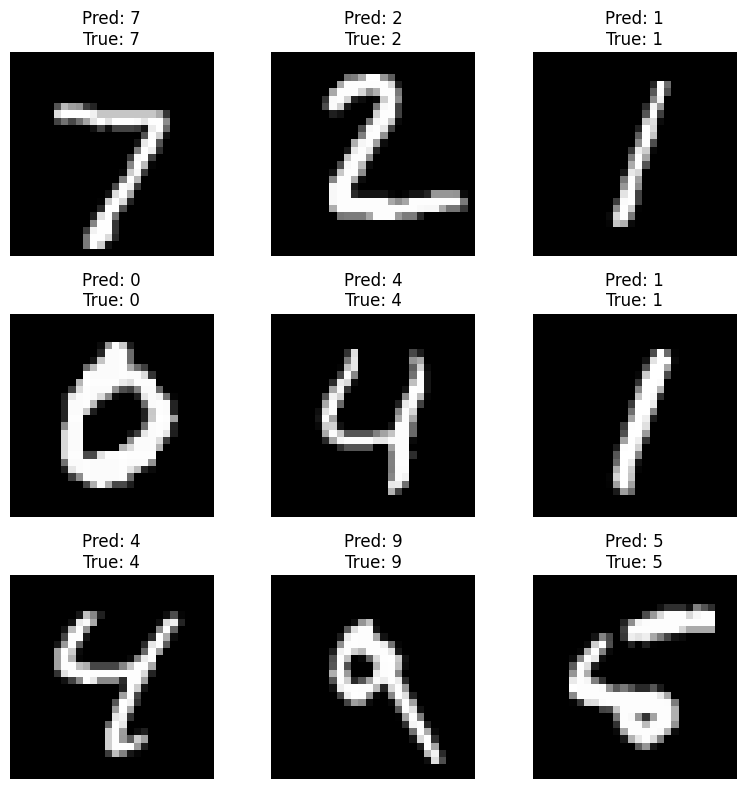


Experiment: Batch Size=128, Learning Rate=0.001, Dropout=0.5
Epoch 1, Loss: 0.2745
Epoch 2, Loss: 0.0669
Epoch 3, Loss: 0.0475
Epoch 4, Loss: 0.0368
Epoch 5, Loss: 0.0299
Test Accuracy: 98.92%


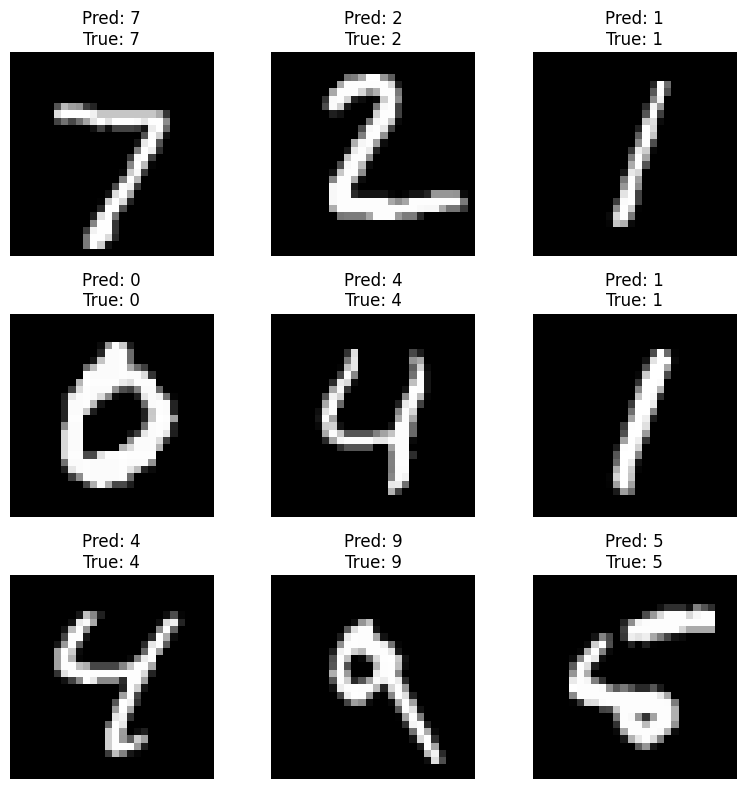


Experiment: Batch Size=32, Learning Rate=0.0001, Dropout=0.5
Epoch 1, Loss: 0.4981
Epoch 2, Loss: 0.1239
Epoch 3, Loss: 0.0863
Epoch 4, Loss: 0.0692
Epoch 5, Loss: 0.0588
Test Accuracy: 98.45%


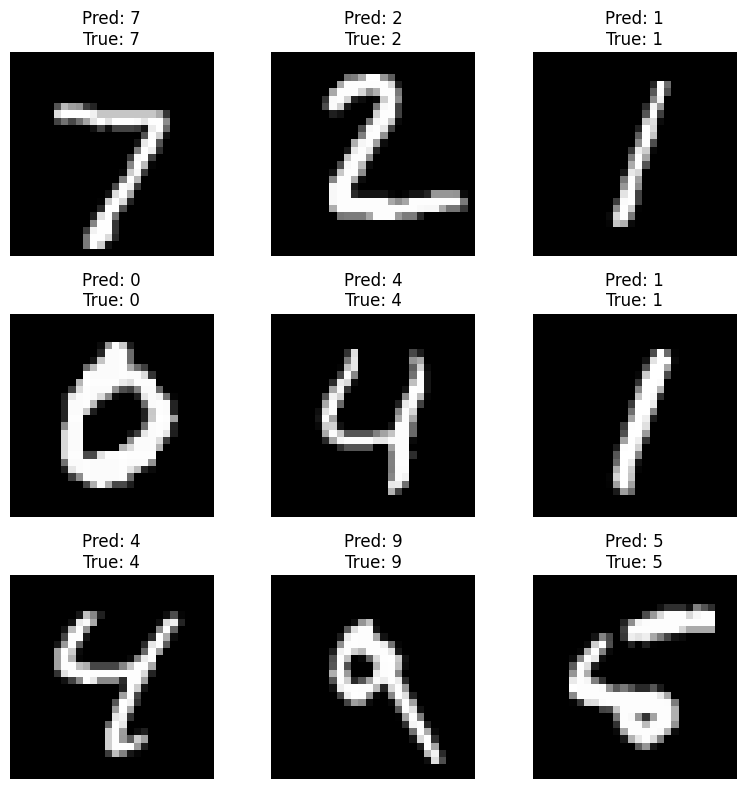

In [21]:
import matplotlib.pyplot as plt

# Hyperparameter configurations
experiments = [
    {"batch_size": 32, "lr": 0.001},
    {"batch_size": 128, "lr": 0.001},
    {"batch_size": 32, "lr": 0.0001},
]

# Run experiments
for exp in experiments:
    batch_size = exp["batch_size"]
    lr = exp["lr"]
    print(f"\nExperiment: Batch Size={batch_size}, Learning Rate={lr}, Dropout=0.5")

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate and collect images for visualization
    model.eval()
    correct = 0
    total = 0
    images_list = []
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if len(predictions) < 9:  # Collect up to 9 images for 3x3 grid
                num_to_collect = min(9 - len(predictions), images.size(0))
                predictions.extend(predicted[:num_to_collect].cpu().numpy())
                true_labels.extend(labels[:num_to_collect].cpu().numpy())
                images_list.extend(images[:num_to_collect].cpu().numpy())


    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Visualize predictions
    plt.figure(figsize=(8, 8))
    for i in range(len(images_list)): # Iterate up to the number of collected images
        plt.subplot(3, 3, i+1)
        img = images_list[i].squeeze() * 0.5 + 0.5  # Rescale image from [-1, 1] to [0, 1]
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {predictions[i]}\nTrue: {true_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()